# Twitter Queries

In [3]:
import requests
from requests_oauthlib import OAuth1
 
q = 'premier league -filter:retweets AND -filter:replies'
 
url = 'https://api.Twitter.com/1.1/search/tweets.json' ### url to Twitter API
 
pms = {'q' : q, 'count' : 100, 'lang' : 'en', 'result_type': 'recent'} ### parameters according to Twitter API
 
consumer_key = ""
consumer_secret = ""
access_token = ""
access_token_secret = ""
    
auth = OAuth1(consumer_key, consumer_secret, access_token, access_token_secret)	
 
res = requests.get(url, params = pms, auth=auth)

tweets = res.json()

In [ ]:
tweets['statuses']

In [ ]:
tweets['statuses'][0]['text']

# Pagination

In [ ]:
#Iterate through 100 pages with tweets and save the data into MongoDB

from pymongo import MongoClient

client = MongoClient('localhost:27017')
db = client.twitter
collection = db.tweets

pages_counter = 0
number_of_pages = 100

while pages_counter < number_of_pages:
    pages_counter += 1
    res = requests.get(url, params = pms, auth=auth)
    print("Connection status: %s" % res.reason)
    tweets = res.json()
    ids = [i['id'] for i in tweets['statuses']]	 # collect ids of all tweets to select min(val)
    pms['max_id'] = min(ids) - 1 # because it would include and then duplicate
    collection.insert_many(tweets['statuses']) 


# Stream API

In [ ]:
from pymongo import MongoClient
from requests_oauthlib import OAuth1
 
client = MongoClient('mongodb://localhost:27017/')
db = client['test']
collection = db['test']

url = 'https://stream.Twitter.com/1.1/statuses/filter.json' 
auth = OAuth1(consumer_key, consumer_secret, access_token, access_token_secret)

pms = {'track' : 'premier league -filter:retweets AND -filter:replies', 'lang': 'en'}

res = requests.post(url, auth=auth, params = pms, stream = True)
 
for line in res.iter_lines():   
    if line:
        tweet = json.loads(line)
        try:
           collection.insert(tweet)
        except:
            pass

# Data Pull

In [ ]:
import json
import pandas as pd
from bs4 import BeautifulSoup
from pymongo import MongoClient

 
client = MongoClient('mongodb://localhost:27017/')
db = client['twitter']
collection = db['tweets']
 
documents = []
for doc in collection.find():
    documents.append(doc)
    
df = pd.DataFrame(documents)
                     

df['tweet_source'] = df['source'].apply(lambda x: BeautifulSoup(x).get_text())

devices = list(set(df[df['tweet_source'].str.startswith('Twitter')]['tweet_source']))
                     
devices.remove('Twitter Ads')
                     
df = df[df['tweet_source'].isin(devices)]
                     
df = df[~df['text'].str.contains("Ghana|ghana|jamaica|Jamaica|Ladbrokes|India|Pakistan|Ghana Premier League|Vijay|Predictions|Egyptian Premier League|cricket|Kings|Caribbean Premier League|@cricbuzz|Cricinfo")]
                     
                     

In [ ]:
df.tweet_source

In [58]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import string
 
df['tokens'] = df['text'].apply(TweetTokenizer().tokenize)
 
stopwords_vocabulary = stopwords.words('english')
df['stopwords'] = df['tokens'].apply(lambda x: [i for i in x if i.lower() not in stopwords_vocabulary])
 
punctuations = list(string.punctuation)
 
df['punctuation'] = df['stopwords'].apply(lambda x: [i for i in x if i not in punctuations])
df['digits'] = df['punctuation'].apply(lambda x: [i for i in x if i[0] not in list(string.digits)])
df['final'] = df['digits'].apply(lambda x: [i for i in x if len(i) > 1])

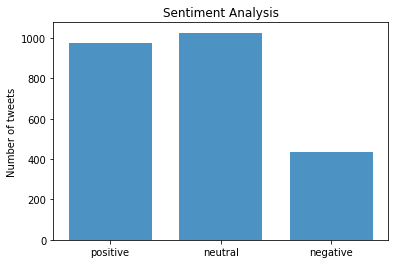

In [64]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
 
sentiment = SentimentIntensityAnalyzer()
 
df['sentiment'] = df.text.apply(lambda x: sentiment.polarity_scores(x)['compound'])

#sentiment.polarity_scores(text) #test method

pos = len(df[df.sentiment > 0])
neg = len(df[df.sentiment < 0])
neu = len(df[df.sentiment == 0])

y = [pos, neu, neg]	# vector of y-values
 
plt.title("Sentiment Analysis")
plt.ylabel('Number of tweets')
plt.xticks(range(len(y)), ['positive', 'neutral', 'negative'])
plt.bar(range(len(y)), height=y, width = 0.75, align = 'center', alpha = 0.8)
 
plt.show()


# Customized sentiment analysis

In [75]:
#You need to tag the dataset before
dataset  = pd.read_pickle('tagged.pickle')

classes = ['pos', 'neu', 'neg']
train_data = dataset['final'][0:80]
train_labels = dataset['label'][0:80]
test_data = dataset['final'][80:96]
test_labels = dataset['label'][80:96]
train_data = list(train_data.apply(' '.join))
test_data = list(test_data.apply(' '.join))

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

vectorizer = TfidfVectorizer(min_df=5, max_df = 0.8, sublinear_tf=True, use_idf=True)

train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)

### Perform a logistic regression model, and fit with X and y

nb = MultinomialNB()

nb.fit(train_vectors, train_labels).score(test_vectors, test_labels)

0.6875

# NER Recognition

In [ ]:
from nltk.tag import StanfordNERTagger
from collections import Counter
import numpy as np

st = StanfordNERTagger('path_to_your_folder/english.all.3class.distsim.crf.ser.gz') 
st.tag(sentence.split())

for r in tweets:
    lst_tags = st.tag(r.split())

for tup in lst_tags:
    if(tup[1] != 'O'):
        entities.append(tup)

In [ ]:
organizations = df_entities[df_entities['ner'].str.contains("ORGANIZATION")]

cnt = Counter(organizations['word'])
cnt.most_common(10)

# Combining NER and sentiment analysis

In [ ]:
subset = dataset[dataset['tweet'].str.contains('Liverpool')]
avg_sentiment = np.mean(subset['sentiment'])